In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, roc_curve, auc
)
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

In [2]:
DATA_TEST = r"C:\Users\caovi\OneDrive\Desktop\projet annuel\core\plank_model\data\plank_test_keypoints.csv"
MODEL_PATH = r"C:\Users\caovi\OneDrive\Desktop\projet annuel\core\plank_model\model\plank_mlp_keypoints.pt"
SCALER_PATH = r"C:\Users\caovi\OneDrive\Desktop\projet annuel\core\plank_model\model\scaler_keypoints.pkl"

df = pd.read_csv(DATA_TEST)
X = df.drop("label", axis=1).values
y = df["label"].values

print("Test dataset:", X.shape, y.shape)

Test dataset: (787, 68) (787,)


In [3]:
with open(SCALER_PATH, "rb") as f:
    scaler = pickle.load(f)

X = scaler.transform(X)

X_tensor = torch.tensor(X, dtype=torch.float32)


# Load model


input_dim = X.shape[1]

class MLP_Model(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1)
        )
        
    def forward(self, x):
        return self.net(x)

model = MLP_Model(input_dim)
model.load_state_dict(torch.load(MODEL_PATH))
model.eval()

C:\Users\caovi\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\caovi\AppData\Local\Temp\ipykernel_17788\2934296813.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for 

MLP_Model(
  (net): Sequential(
    (0): Linear(in_features=68, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)


=== METRICS ===
Accuracy : 1.0
Precision: 1.0
Recall   : 1.0
F1 Score : 1.0


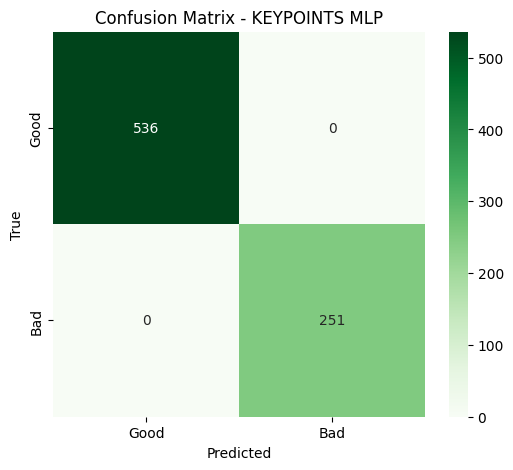

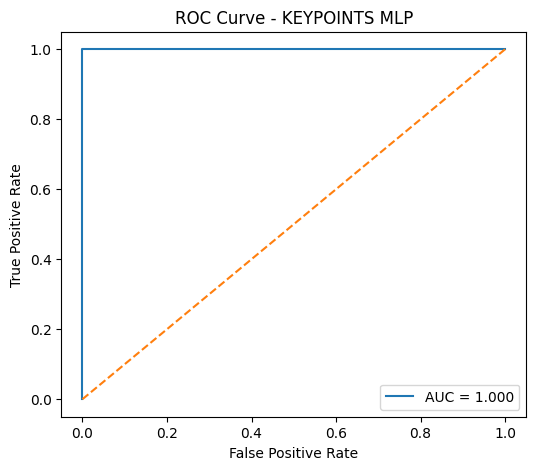

In [4]:
# 4. Predictions

with torch.no_grad():
    logits = model(X_tensor).squeeze()
    probs = torch.sigmoid(logits)
    preds = (probs > 0.5).float().numpy()

# 5. Metrics

acc = accuracy_score(y, preds)
prec = precision_score(y, preds)
rec = recall_score(y, preds)
f1 = f1_score(y, preds)

print("\n=== METRICS ===")
print("Accuracy :", acc)
print("Precision:", prec)
print("Recall   :", rec)
print("F1 Score :", f1)

# 6. Confusion Matrix

cm = confusion_matrix(y, preds)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens",
            xticklabels=["Good", "Bad"],
            yticklabels=["Good", "Bad"])
plt.title("Confusion Matrix - KEYPOINTS MLP")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# 7. ROC Curve

fpr, tpr, _ = roc_curve(y, probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1],[0,1],"--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - KEYPOINTS MLP")
plt.legend()
plt.show()